# Chess Agent ♛

## Import dependencies

The dataset is from a free and open source chess serves, [Lichess](https://lichess.org/), filtered by elite players rated 2400+ against players rated 2200+.

[Litchess Elite Database](https://database.nikonoel.fr/)

In [5]:
!pip install chess python-lichess


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
import chess
import chess.pgn
import lichess.api
from lichess.format import SINGLE_PGN

import chess.engine
import asyncio

import transformers 
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoTokenizer
import re

## Load data

Chess games are often stored in PGN format, which is just a text file with information about the game and the moves.

In [7]:
filepath = r"data\lichess_elite_2013-09.pgn"

pgn = open(filepath)
print(pgn)

<_io.TextIOWrapper name='data\\lichess_elite_2013-09.pgn' mode='r' encoding='cp1250'>


In [8]:
while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    board = game.board()
    
    for i, move in enumerate(game.mainline_moves()):
        print(board.fen())
        #print(move)
        board.push(move)
        if i == 40:
            break
    print("-----------------")


rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
rnbqkbnr/ppp1pppp/8/3p4/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
rnbqkbnr/ppp1pppp/8/3P4/8/8/PPPP1PPP/RNBQKBNR b KQkq - 0 2
rnb1kbnr/ppp1pppp/8/3q4/8/8/PPPP1PPP/RNBQKBNR w KQkq - 0 3
rnb1kbnr/ppp1pppp/8/3q4/8/2N5/PPPP1PPP/R1BQKBNR b KQkq - 1 3
rnb1kbnr/ppp1pppp/8/q7/8/2N5/PPPP1PPP/R1BQKBNR w KQkq - 2 4
rnb1kbnr/ppp1pppp/8/q7/3P4/2N5/PPP2PPP/R1BQKBNR b KQkq - 0 4
rnb1kbnr/pp2pppp/2p5/q7/3P4/2N5/PPP2PPP/R1BQKBNR w KQkq - 0 5
rnb1kbnr/pp2pppp/2p5/q7/3P4/2N2N2/PPP2PPP/R1BQKB1R b KQkq - 1 5
rnb1kb1r/pp2pppp/2p2n2/q7/3P4/2N2N2/PPP2PPP/R1BQKB1R w KQkq - 2 6
rnb1kb1r/pp2pppp/2p2n2/q7/2BP4/2N2N2/PPP2PPP/R1BQK2R b KQkq - 3 6
rn2kb1r/pp2pppp/2p2n2/q7/2BP2b1/2N2N2/PPP2PPP/R1BQK2R w KQkq - 4 7
rn2kb1r/pp2pppp/2p2n2/q7/2BP2b1/2N2N1P/PPP2PP1/R1BQK2R b KQkq - 0 7
rn2kb1r/pp2pppp/2p2n2/q6b/2BP4/2N2N1P/PPP2PP1/R1BQK2R w KQkq - 1 8
rn2kb1r/pp2pppp/2p2n2/q6b/2BP4/2N2N1P/PPP2PP1/R1BQ1RK1 b kq - 2

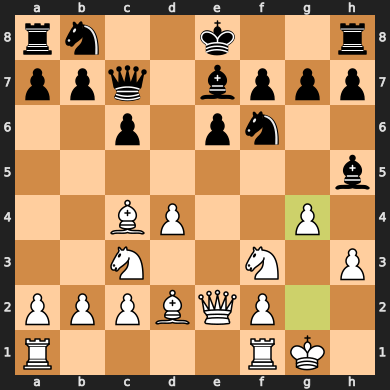

In [70]:
board

## LLM

In [65]:
#Example of how to use the chess library
board = chess.Board(fen=chess.STARTING_FEN)
board.push_san("e4")
board.push_san("b6")
board.push_san("Nf3")
board.push_san("Bb7")
board.push_san("d4")
board.push_san("e6")
board.push_san("Nc3")
board.push_san("Bb4")

Move.from_uci('f8b4')

In [ ]:
# Load a small LLM (Mistral-7B)
#model_name = "mistralai/Mistral-7B-Instruct"
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")


Some parameters are on the meta device because they were offloaded to the disk and cpu.


In [70]:
def get_prompt(board, history="No moves yet. Start the game.", score=0.0, wrong_moves=None):
    if (wrong_moves):
        return f"You are a chess expert playing a chess game. The last moves \
            in the game were: \n{history}\nThe board position in FEN format: \
            \n{board.fen()}\n\nCurrent evaluation score: {score}\n\nDon't recommend any of the moves of {', '.join(wrong_moves)} \
            you played was invalid. Please respond with a move in UCI notation."
    else:
        return f"You are a chess expert playing a chess game. The last moves \
            in the game were: \n{history}\nThe board position in FEN format: \
            \n{board.fen()}\n\nCurrent evaluation score: {score}\n\nWhat is the\
            next move? Only respond with your move in UCI notation."


In [73]:
def is_valid_response(response, board):
    # Normalize the response
    stripped = response.strip().lower()
    
    # Regex pattern for valid UCI format
    if not re.fullmatch(r"^[a-h][1-8][a-h][1-8](?:[qrnb])?$", stripped):
        print(f"Invalid UCI format: '{response}'. Must be 4-5 characters like 'e2e4' or 'a7a8q'")
        return None
    
    try:
        move = board.parse_uci(stripped)
    except ValueError:
        print(f"Invalid chess move syntax: '{stripped}'")
        return None

    # Check if move is legal in current position
    if move not in board.legal_moves:
        print(f"Illegal move in current position: '{stripped}'")
        return None
        
    return move

In [ ]:
def generate_move(board, score=0.0, attempts=5):
    """Generates a move from a given FEN using LLM"""
    #Collect history of last 5 moves
    history = ""
    for move in board.move_stack[-5:]:
        history = history + move.uci() + "\n"

    # Tokenize input
    wrong_moves = []

    # Generate response
    for attempt in attempts:
        prompt = get_prompt(board, score, wrong_moves)        
        inputs = tokenizer(prompt, return_tensors="pt")

        with torch.no_grad():
            output = model.generate(**inputs)

        # Decode response
        response = tokenizer.decode(output) #might need skip_special_tokens=True
        suggested_move = is_valid_response(response, board)
        #Validate move, and return it
        if suggested_move is None:
            #if the move is invalid prompt the model again, with the incorrect move
            wrong_moves.append(response)
        else:
            return suggested_move 

    #If no valid move is found before the max number of attempts, return error and loose
    raise Exception("No valid move found after 5 attempts")
    return None

def validate_and_play(board):
    """Validates the move and updates board state"""
    move = generate_move(board)

    if move in [m.uci() for m in board.legal_moves]:
        board.push_uci(move)
        board.is_legal(move)
        print(f"Move Played: {move}")
    else:
        print(f"Invalid Move Suggested: {move}")

    return [True, board.fen()]

print(generate_move(board))


You are a chess expert playing a chess game. The last moves in the game were: 
c8b7
d2d4
e7e6
b1c3
f8b4

The board position in FEN format: 
rn1qk1nr/pbpp1ppp/1p2p3/8/1b1PP3/2N2N2/PPP2PPP/R1BQKB1R w KQkq - 2 5

Current evaliation score: 0.0

What is the next move? Only respond with your move in UCI notation.


In [254]:

#model = "PY007/TinyLlama-1.1B-Chat-v0.1"
#tokenizer = AutoTokenizer.from_pretrained(model)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)

formatted_prompt = get_prompt(board)

sequences = pipeline(
    formatted_prompt,
    do_sample=True,
    top_k=50,
    top_p = 0.9,
    num_return_sequences=1,
    repetition_penalty=1.1,
    max_new_tokens=1024,
)
for seq in sequences:
    print(f"Result: {seq['generated_text']}")

Exception: Impossible to guess which tokenizer to use. Please provide a PreTrainedTokenizer class or a path/identifier to a pretrained tokenizer.

## TODO:

- Game between LLM prompts and Stockfish engine
    - if out of attempts the model should loose the game
    - loop for game 
- Evaluate the ACPL score for LLM before fine tune it
- Fine tune LLM with all the elite data
- Evaluate again


In [231]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
# Main game loop
def play_game(engine_path):
    board = chess.Board()
    game_over = False
    score = 0

    while not game_over:
        # LLM's turn
        print("\nLLM's Turn:")
        print(board)
        llm_move = generate_move(board, score)
        
        # Validate and apply LLM's move
        if llm_move in [move.uci() for move in board.legal_moves]:
            board.push_uci(llm_move)
            print(f"LLM plays: {llm_move}")
        else:
            print(f"Invalid move by LLM: {llm_move}. Game over.")
            break

        # Check if the game is over after LLM's move
        if board.is_game_over():
            print("Game over!")
            print("Result:", board.result())
            game_over = True
            break

        # Stockfish's turn
        print("\nStockfish's Turn:")
        print(board)
        engine = chess.engine.SimpleEngine.popen_uci(engine_path)
        result = engine.play(board, chess.engine.Limit(time=2.0))
        sf_move = result.move
        board.push(sf_move)
        print(f"Stockfish plays: {sf_move.uci()}")
        info = engine.analyse(board, chess.engine.Limit(depth=20))
        score = info["score"].relative 

        engine.quit()

        # Check if the game is over after Stockfish's move
        if board.is_game_over():
            print("Game over!")
            print("Result:", board.result())
            game_over = True



In [ ]:
# Path to Stockfish executable
engine_path = r"stockfish/stockfish-windows-x86-64-avx2.exe"  # Adjust path as needed

# Start the game
play_game(engine_path)

In [ ]:
def evaluate_position(board, engine_path):
    engine = chess.engine.SimpleEngine.popen_uci(engine_path)
    
    info = engine.analyse(board, chess.engine.Limit(depth=20))  
    evaluation = info["score"].relative  # Positive means White is better

    engine.quit()
    
    return evaluation

In [235]:
def evaluate_game(pgn):
    board = chess.Board()
    engine_path = "stockfish/stockfish-windows-x86-64-avx2.exe"
    engine = chess.engine.SimpleEngine.popen_uci(engine_path)

    evaluations = []
    for move in pgn.split():
        board.push_san(move)  # Play the move
        info = engine.analyse(board, chess.engine.Limit(depth=15))
        evaluations.append(info["score"].relative.score(mate_score=10000))  # Convert mate to a large number

    engine.quit()
    return evaluations

#pgn_game = "1. e4 e5 2. Nf3 Nc6 3. Bb5 a6"  # Example game
print(evaluate_game(pgn))

AttributeError: '_io.TextIOWrapper' object has no attribute 'split'